In [1]:
# import libraries

import os
from operator import index

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')


In [2]:
os.chdir('res')

In [3]:
# load data and EDA
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.drop(columns=['id'],inplace=True)
df.head()
# unbalanced dataset detected.

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
stroke_0_df = df[df['stroke'] == 0]
stroke_1_df = df[df['stroke'] == 1]

num_rows = len(stroke_1_df) * 2

rate = num_rows / len(stroke_0_df)


stroke_0_df_reduced = stroke_0_df.sample(frac = rate, random_state = 42)

balanced_df = pd.concat([stroke_0_df_reduced,stroke_1_df])

df = balanced_df.sample(frac = 1, random_state = 42)


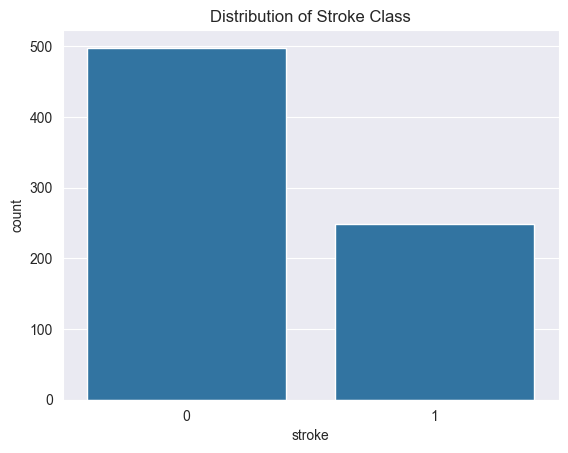

In [5]:
# stroke labels
plt.figure()
sns.countplot(x = 'stroke', data=df)
plt.title('Distribution of Stroke Class')
plt.show()

In [6]:
# missing value : decision tree regressor
df.isna().sum()
# bmi <-> age/ gender

steps = [('scale',StandardScaler()), # data standardization
         ('dtr',DecisionTreeRegressor(random_state=42))] # dtr model

DT_bmi_pipe = Pipeline(steps=steps)

In [7]:
# work type, age, smoking_status, avg_glucose_level
X = df[['work_type','age','smoking_status','avg_glucose_level','bmi']].copy()
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 747 entries, 4686 to 3129
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   work_type          747 non-null    object 
 1   age                747 non-null    float64
 2   smoking_status     747 non-null    object 
 3   avg_glucose_level  747 non-null    float64
 4   bmi                687 non-null    float64
dtypes: float64(3), object(2)
memory usage: 35.0+ KB


In [8]:
work_type_dict = {'Private' : 1,
                  'Self-employed' : 3,
                  'Govt_job' : 2,
                  'children' : -1,
                  'Never_worked' : 0}

smoking_status_dict = {'never smoked' : 0,
                       'smokes' : 1,
                       'formerly smoked' : 2,
                       'Unknown' : -1}

In [9]:
def cnvrt_cat2num(col,col_dict,data = X):
    data[col].replace(col_dict,inplace=True)
    data[col] = pd.to_numeric(data[col],errors='coerce')
    
X['work_type'].replace(work_type_dict,inplace=True)
X['smoking_status'].replace(smoking_status_dict,inplace=True)

In [10]:
# nan bmi values rows
missing_data = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
y = X.pop('bmi')
y

4686    25.0
275     28.4
2732    33.2
3983    24.8
3606    52.5
        ... 
202     32.0
4890    23.4
3209    33.2
4492    16.1
3129    20.3
Name: bmi, Length: 687, dtype: float64

In [11]:
X

,work_type,age,smoking_status,avg_glucose_level
4686,3,70.0,0,96.82
275,2,67.0,1,94.61
2732,2,58.0,0,59.52
3983,1,51.0,2,95.70
3606,3,45.0,-1,239.19
...,...,...,...,...
202,3,77.0,0,90.00
4890,1,56.0,0,66.32
3209,1,67.0,2,65.51
4492,-1,8.0,-1,87.15


In [12]:
# train model with full data
DT_bmi_pipe.fit(X,y)

# predict missing bmi data
# use gender and age

params = ['work_type','age','smoking_status','avg_glucose_level']
predicted_bmi = pd.Series(DT_bmi_pipe.predict(missing_data[params]), index = missing_data.index)
df.loc[missing_data.index, 'bmi'] = predicted_bmi
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [13]:
df_copied = df.copy()
df_copied

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4686,Female,70.0,0,0,Yes,Self-employed,Rural,96.82,25.0,never smoked,0
275,Female,67.0,0,0,Yes,Govt_job,Rural,94.61,28.4,smokes,0
2732,Female,58.0,1,0,Yes,Govt_job,Rural,59.52,33.2,never smoked,0
3983,Female,51.0,0,0,Yes,Private,Urban,95.70,24.8,formerly smoked,0
3606,Male,45.0,1,0,Yes,Self-employed,Rural,239.19,52.5,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
4890,Female,56.0,0,0,Yes,Private,Urban,66.32,23.4,never smoked,0
3209,Male,67.0,0,0,Yes,Private,Rural,65.51,33.2,formerly smoked,0
4492,Female,8.0,0,0,No,children,Urban,87.15,16.1,Unknown,0
2215,Male,67.0,0,1,Yes,Private,Rural,97.24,31.3,Unknown,0


In [14]:
work_type_dict = {'Private' : 1,
                  'Self-employed' : 3,
                  'Govt_job' : 2,
                  'children' : -1,
                  'Never_worked' : 0}

residence_type_dict = {'Urban' : 0,
                       'Rural' : 1 }

smoking_status_dict = {'never smoked' : 0,
                       'smokes' : 1,
                       'formerly smoked' : 2,
                       'Unknown' : -1}

gender_dict = {'Male' : 1,
               'Female' : 0,
               'Other' : -1}

ever_married_dict = {'No' : 0 , 'Yes' : 1}

In [15]:
df_copied.info()

<class 'pandas.core.frame.DataFrame'>
Index: 747 entries, 4686 to 3129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             747 non-null    object 
 1   age                747 non-null    float64
 2   hypertension       747 non-null    int64  
 3   heart_disease      747 non-null    int64  
 4   ever_married       747 non-null    object 
 5   work_type          747 non-null    object 
 6   Residence_type     747 non-null    object 
 7   avg_glucose_level  747 non-null    float64
 8   bmi                747 non-null    float64
 9   smoking_status     747 non-null    object 
 10  stroke             747 non-null    int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 86.2+ KB


In [16]:
cnvrt_cat2num('work_type',work_type_dict,df_copied)
cnvrt_cat2num('smoking_status',smoking_status_dict,df_copied)
cnvrt_cat2num('Residence_type',residence_type_dict,df_copied)
cnvrt_cat2num('gender',gender_dict,df_copied)
cnvrt_cat2num('ever_married',ever_married_dict,df_copied)

In [17]:
df_copied.info()

<class 'pandas.core.frame.DataFrame'>
Index: 747 entries, 4686 to 3129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             747 non-null    int64  
 1   age                747 non-null    float64
 2   hypertension       747 non-null    int64  
 3   heart_disease      747 non-null    int64  
 4   ever_married       747 non-null    int64  
 5   work_type          747 non-null    int64  
 6   Residence_type     747 non-null    int64  
 7   avg_glucose_level  747 non-null    float64
 8   bmi                747 non-null    float64
 9   smoking_status     747 non-null    int64  
 10  stroke             747 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 86.2 KB


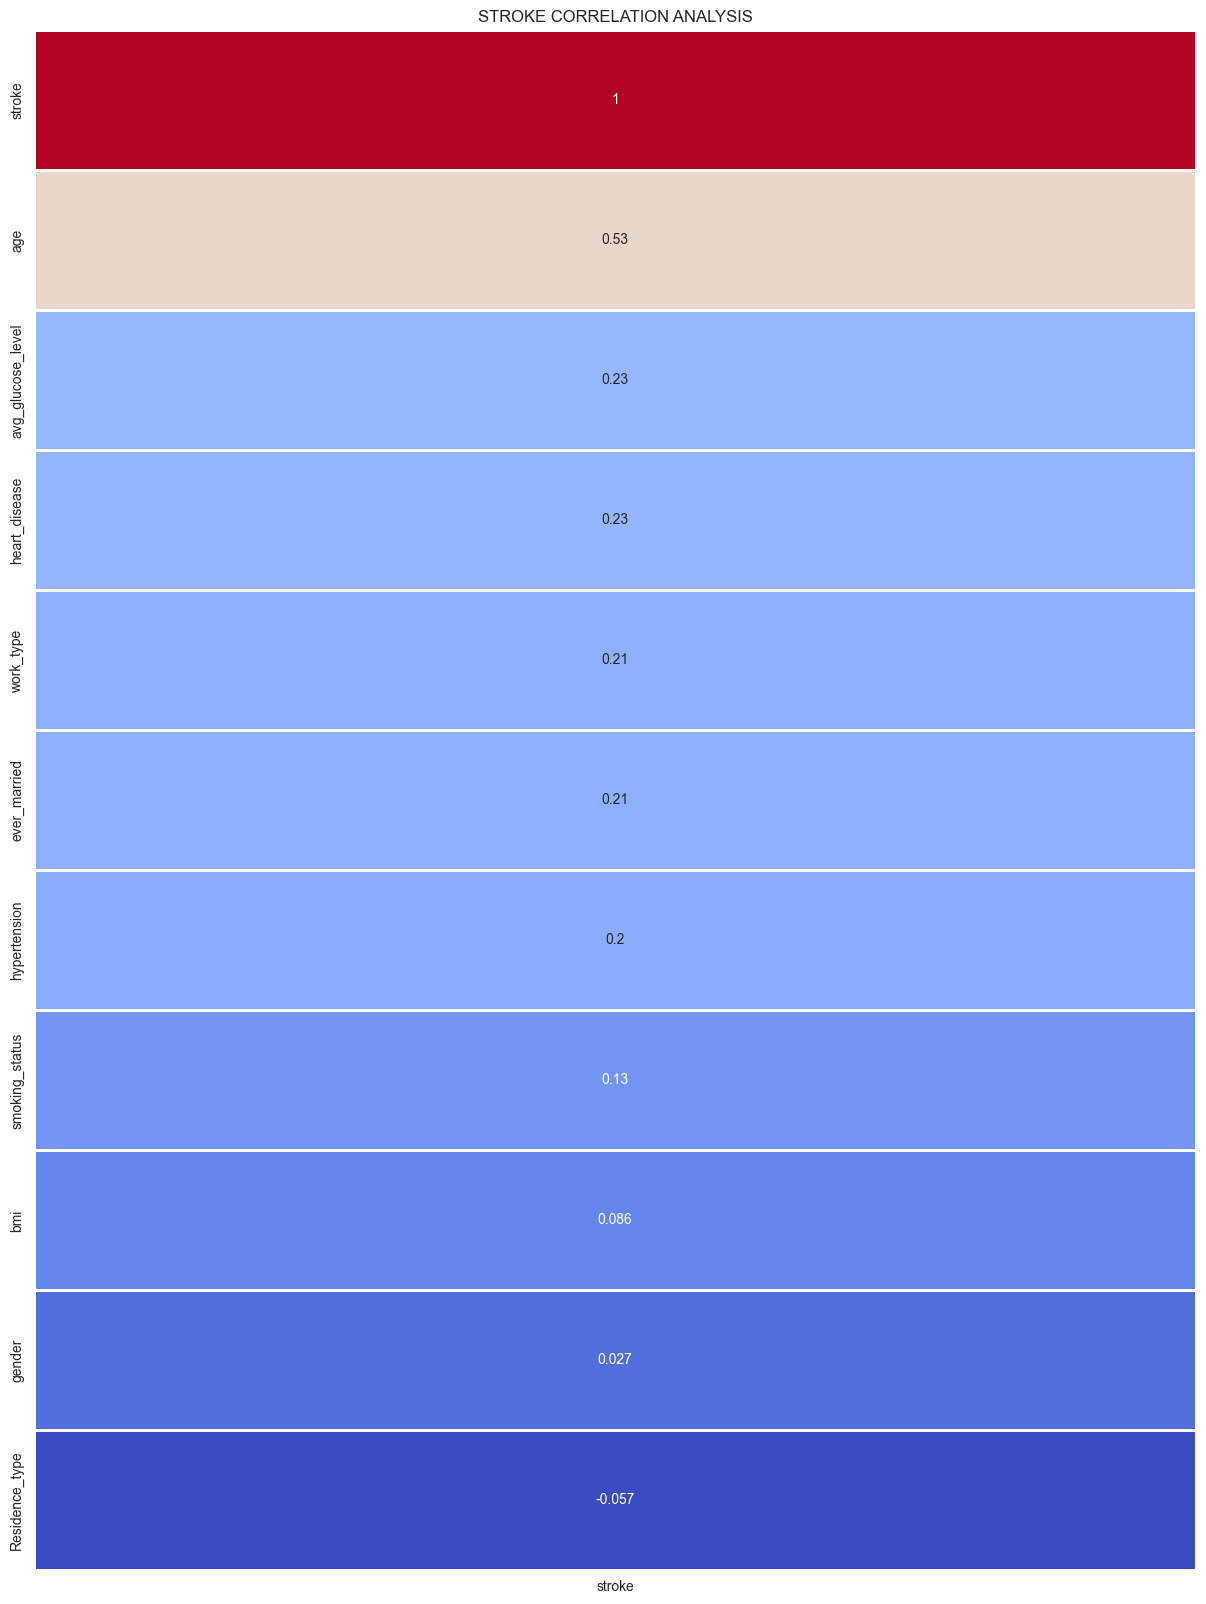

In [18]:
plt.figure(figsize=(15,20))
sns.heatmap(df_copied.select_dtypes(include=['number']).corr()[['stroke']].sort_values(by='stroke',ascending=False),
            annot=True, linewidths=2, linecolor='white',cbar=False, cmap = 'coolwarm')
plt.title('STROKE CORRELATION ANALYSIS')
plt.show()

In [19]:
X = df_copied[['age','heart_disease','avg_glucose_level','hypertension','ever_married']]
y = df_copied['stroke']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [21]:
steps = [('scale',StandardScaler()), ('LR',LogisticRegression())]
log_reg_pipe = Pipeline(steps=steps)

In [22]:
# model training
log_reg_pipe.fit(X_train, y_train)

# model test
y_pred = log_reg_pipe.predict(X_test)


In [23]:
print("accuracy : \n",accuracy_score(y_test, y_pred))
print("cr : \n",classification_report(y_test, y_pred))   
print("cm : \n",confusion_matrix(y_test, y_pred))


accuracy : 
 0.84
cr : 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88        49
           1       0.79      0.73      0.76        26

    accuracy                           0.84        75
   macro avg       0.83      0.81      0.82        75
weighted avg       0.84      0.84      0.84        75

cm : 
 [[44  5]
 [ 7 19]]
